<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.2.0'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [8]:
wl_range = np.load('wl_range_galaxies_only.npy')


In [9]:
### settings
# user defined span (following Yip et al and Portillo et al)
wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'

In [10]:
# wl_range      = np.load('wl_range_%s.npy'%label)
# wl_range      = (np.log10(wlmin),np.log10(wlmax))

wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [34]:
res_fluxes,res_inv_vars,res_masks,redshifts,SNs, ras, decs, sublabel = np.load('/global/cscratch1/sd/vboehm/Datasets/SDSS_BOSS_preprocessed/%s.npy'%label, allow_pickle=True)

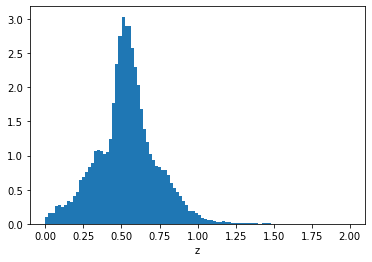

In [35]:
_ = plt.hist(redshifts,bins=100,density=True)
plt.xlabel('z')
plt.show()

In [36]:
res_fluxes_   = np.asarray(list(res_fluxes))
res_inv_vars_ = np.asarray(list(res_inv_vars))
res_masks_    = np.asarray(list(res_masks))

In [37]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    indx = np.where((redshifts>min_z)*(redshifts<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, sublabel = redshift_bin(min_z, max_z, redshifts, [res_fluxes_, res_masks_, res_inv_vars_, redshifts, ras, decs, sublabel])

new datasize:  82602


In [38]:
DATASET_SIZE = len(res_fluxes)

In [39]:
SNs =[]
for ii in range(DATASET_SIZE):
    SNs.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])//np.sqrt(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])])))
SNs= np.asarray(SNs)

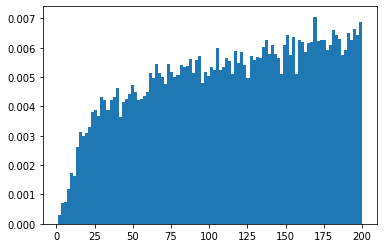

In [40]:
_ = plt.hist(SNs, density=True,bins=100,range=(1,200))

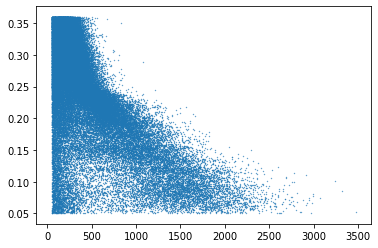

In [55]:
plt.scatter(SNs,redshifts, s=0.1)

In [42]:
def SN_bin(min_SN, SNs, arrays):
    num  = len(arrays)
    indx = np.where(SNs>min_SN)[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, sublabel = SN_bin(min_SN, SNs, [res_fluxes, res_masks, res_inv_vars, redshifts,SNs,ras, decs, sublabel])

new datasize:  77990


In [43]:
boolean_mask = (res_masks==0)

In [44]:
mask_fracs = np.mean(boolean_mask,axis=1)

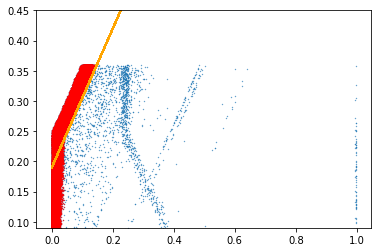

In [45]:
plt.scatter(mask_fracs, redshifts, s=0.1)
plt.plot(mask_fracs,mask_fracs*1.15+0.19, color='orange')
keep = redshifts>mask_fracs*1.15+0.19
keep_low = mask_fracs<0.04
keep = np.logical_or(keep,keep_low)
plt.scatter(mask_fracs[keep], redshifts[keep], color='red', s=0.1)
plt.ylim(0.09,0.45)
plt.show()

In [46]:
def mask_bin(keep, arrays):
    num  = len(arrays)
    arrays_new = [arrays[ii][keep] for ii in range(num)]
    print('new datasize: ', len(arrays_new[0]))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, sublabel = mask_bin(keep, [res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, sublabel])

new datasize:  75925


In [47]:
boolean_mask = (res_masks==0)

In [48]:
mask_fracs = np.mean(boolean_mask,axis=1)
max(mask_fracs)

0.146

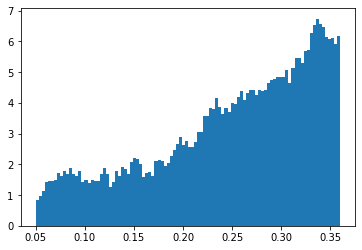

In [49]:
_ = plt.hist(redshifts, density=True, bins=100)

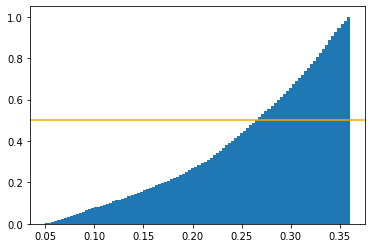

In [50]:
_ = plt.hist(redshifts, density=True, bins=100, cumulative=True)
plt.axhline(0.5,color='orange')

In [51]:
def calc_noise_floor(res_fluxes, res_masks, res_inv_vars):
    floors = []
    sanity = []
    MAXs   = []
    for ii in range(len(res_fluxes)):
        MAX = max(res_fluxes[ii][res_masks[ii]]*np.sqrt(res_inv_vars[ii][res_masks[ii]]))
        MAXs.append(MAX)
        N   = np.where(res_fluxes[ii][res_masks[ii]]*np.sqrt(res_inv_vars[ii][res_masks[ii]])==MAX)[0]
        if MAX>50.:
            print(N)
            floor2 = (res_fluxes[ii][res_masks[ii]][N]/50.)**2-1./res_inv_vars[ii][res_masks[ii]][N]
            sanity.append(res_fluxes[ii][res_masks[ii]][N]/np.sqrt(floor2+1./res_inv_vars[ii][res_masks[ii]][N]))
            floors.append(floor2)
        else:
            floors.append(0.)
    return floors, sanity, MAXs


noise_floors, sanity, MAXs = calc_noise_floor(res_fluxes, res_masks, res_inv_vars)

[990]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 

In [52]:
sanity = np.asarray(sanity)
noise_floors = np.asarray(noise_floors)
MAXs = np.asarray(MAXs)

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


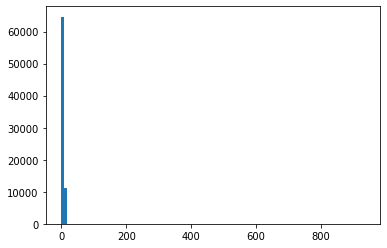

In [53]:
_ = plt.hist(MAXs, bins=100)

In [59]:
np.save('prepped_data_spectra_%s.npy'%label_, [res_fluxes, res_masks, res_inv_vars])

np.save('prepped_data_prop_%s.npy'%label_, [redshifts, SNs, ras, decs, sublabel])

(75925, 1000)
(75925, 1000)
(75925, 1000)
(75925,)
(75925,)
(75925,)
(75925,)
(75925,)
